 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 2: Optimisation sans contraintes
Tangi Migot et Paul Raynaud

Nom : Mohamed Laghdaf HABIBOULLAH

In [ ]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.instantiate()
Pkg.status()


In [4]:
using ADNLPModels, LinearAlgebra, NLPModels, Printf

On pourra trouver de la documentation sur `ADNLPModels` et `NLPModels` ici:
- [juliasmoothoptimizers.github.io/NLPModels.jl/dev/](https://juliasmoothoptimizers.github.io/NLPModels.jl/dev/)
- [juliasmoothoptimizers.github.io/ADNLPModels.jl/dev/](https://juliasmoothoptimizers.github.io/ADNLPModels.jl/dev/)

In [1]:
# Problème test:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2]; -x[1]^2 + 2*x[1]*x[2] + x[1]] # le gradient de f
H(x) = 6 * [2*x[1]-1-2*x[2] -2*x[1]+2*x[2]+1; -2*x[1]+2*x[2]+1 2*x[1]] # la Hessienne de f

H (generic function with 1 method)

### Exercice 1: Newton avec recherche linéaire - amélioration du code

Ci-dessous, vous avez le code de deux fonctions qui ont été vues dans le cours, la recherche linéaire qui satisfait Armijo, et une méthode de Newton avec cette recherche linéaire. Le but de ce laboratoire est d'implémenter d'autres méthodes utiles pour résoudre des problèmes de grandes dimensions.

In [5]:
#Amélioration possibles: return also the value of f
function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

armijo (generic function with 1 method)

In [63]:
"""Test pour vérifier que la fonction armijo fonctionne correctement."""
using Test #le package Test définit (entre autre) la macro @test qui permet de faire des tests unitaires :-)
xk = ones(2)
gk = g(xk)
dk = - gk
fk = f(xk)
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= fk + 1.0e-4 * t * dot(gk,dk)

xk = [1.5, 0.5]
fk = f(xk)
gk = g(xk)
dk = - gk
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= f(xk) + 1.0e-4 * t * dot(g(xk),dk)


Test Passed

In [142]:
function newton_armijo(f, g, H, x0; verbose::Bool = true)
  xk  = x0
  L = [x0]
  fk  = f(xk)
  gk = g(xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100
    Hk = H(xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
    t = armijo(xk, dk, fk, gk, f)
    xk += t * dk
    fk = f(xk)
    gk = g(xk)
    gnorm = norm(gk)
    push!(L, xk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk, L
end

newton_armijo (generic function with 1 method)

In [143]:
sol, L = newton_armijo(f, g, H, [.5, .5])
@test g(sol) ≈ zeros(2) atol = 1.0e-6

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00
 1  5.08e-02   8.4e-01 1.0e+00 
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 


Test Passed

On veut améliorer le code de la fonction `newton_armijo` avec les ajouts suivants:
- Changer les paramètre d'entrées de la fonction pour un `nlp`
- Avant d'appeler la recherche linéaire, si `slope = dot(dk, gk)` est plus grand que `-1.0e-4 * norm(dk) * gnorm`, on modifie le système. On fait maximum 5 mise à jour de `λ`, sinon on prend l'opposé du gradient.
```
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
```
Ajouter un compteur sur le nombre de mises à jour de `λ` et ajuster `dk = - gk` si la limite est atteinte.
- On veut aussi détecter et éventuellement arrêter la boucle `while` si la fonction objectif `fk` devient trop petite/négative (inférieure à `-1e15`), i.e. le problème est non-bornée inférieurement.
- On veut ajouter deux critères d'arrêts supplémentaires: 
  - un compteur sur le nombre d'évaluations de f (maximum 1000). Utiliser `neval_obj(nlp)`.
  -  une limite de temps d'execution, `max_time = 60.0`. Utiliser la fonction `time()`.
- Enfin, on voudrait aussi voir un message à l'écran si l'algorithme n'a pas trouvé la solution, i.e. il s'est arrêté à cause de la limite sur le nombre d'itérations, temps, évaluation de fonctions, problème non-borné.

In [155]:
"""
newton_armijo_amelioré(nlp, x0; verbose::Bool = true, max_time::Float64 = 60.0)

Cette fonction résout un problème d'optimisation non-linéaire en utilisant la méthode de Newton avec recherche linéaire de type Armijo.
"""
function newton_armijo_amelioré(nlp, x0; verbose::Bool = true, max_time::Float64 = 60.0)
  xk  = x0
  L = [x0]
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
 # comp_f = neval_obj(nlp)
  t = time()
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 #&& time() - t < max_time
    Hk = hess(nlp, xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    iter = 0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm && iter < 5
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
      iter += 1
    end
    if iter == 5
      dk = - gk
    end
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    push!(L, xk)
    fk = obj(nlp, xk)
    if fk < -1e15
      println("fk = $fk")
      return xk, L
    end
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  println("c'est fini")
  return xk, L
end

newton_armijo_amelioré (generic function with 1 method)

In [156]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = [0.5, 0.5]
nlp = ADNLPModel(f, x0)

sol, _ = newton_armijo_amelioré(nlp, x0)
@test g(sol) ≈ zeros(2) atol = 1.0e-6

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00
 1  5.08e-02   8.4e-01 1.0e+00 
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 
c'est fini


Test Passed

In [157]:
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  ForwardDiffADJprod,
  ForwardDiffADJtprod,
  SparseForwardADJacobian,
  ForwardDiffADHessian,
  ForwardDiffADGHjvprod,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
   

In [158]:
#Unit/Validation Tests
ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
sol, _ = newton_armijo_amelioré(himmelblau, himmelblau.meta.x0, verbose = true, max_time = 60.0) 
println(grad(himmelblau, sol))
println(obj(himmelblau, sol))

 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  3.35e+04   9.7e+03 1.0e+00 
 2  6.24e+03   2.8e+03 1.0e+00 
 3  1.10e+03   8.2e+02 1.0e+00 
 4  1.81e+02   2.3e+02 1.0e+00 
 5  2.69e+01   6.2e+01 1.0e+00 
 6  2.68e+00   1.5e+01 1.0e+00 
 7  1.00e-01   2.6e+00 1.0e+00 
 8  3.28e-04   1.4e-01 1.0e+00 
 9  4.53e-09   5.3e-04 1.0e+00 
c'est fini
[6.476529855071259e-5, 0.0005246832730481549]
4.526147454270736e-9


In [159]:
# Test de la fonction newton_armijo_amelioré avec rozennbrock
roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
sol, _ = newton_armijo_amelioré(rosenbrock, rosenbrock.meta.x0, verbose = true) 
@test sol ≈ [1., 1.] atol = ep2

 k        fk ||∇f(x)||
 0  2.42e+01   2.3e+02


 1  4.73e+00   4.6e+00 1.0e+00 
 2  4.12e+00   3.1e+01 1.3e-01 
 3  3.22e+00   1.0e+01 1.0e+00 
 4  2.84e+00   2.3e+01 6.7e-01 
 5  2.05e+00   5.1e+00 1.0e+00 
 6  1.73e+00   1.2e+01 4.4e-01 
 7  1.24e+00   3.8e+00 1.0e+00 
 8  1.03e+00   9.5e+00 6.7e-01 
 9  6.69e-01   1.8e+00 1.0e+00 
10  6.08e-01   1.2e+01 6.7e-01 
11  2.95e-01   8.0e-01 1.0e+00 
12  2.13e-01   7.2e+00 4.4e-01 
13  1.07e-01   9.9e-01 1.0e+00 
14  6.57e-02   5.3e+00 6.7e-01 
15  2.50e-02   8.0e-01 1.0e+00 
16  1.35e-02   4.3e+00 1.0e+00 
17  1.35e-03   8.0e-02 1.0e+00 
18  1.45e-04   5.3e-01 1.0e+00 
19  1.77e-07   7.5e-04 1.0e+00 
20  3.16e-12   7.8e-05 1.0e+00 
c'est fini


Test Passed

In [160]:
"""
Test de la fonction newton_armijo_amelioré avec différents problèmes du fichier test_set1.jl
"""

@testset "Test set for newton_armijo_amelioré" begin
	#Test problem:
	fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
	x0H = [10., 20.]
	himmelblau = ADNLPModel(fH, x0H)

	problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))

	roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
	rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

	f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
	pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]


	
	######################################### newton_armijo ##################

	#Unit/Validation Tests
    ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
	sol, _ = newton_armijo_amelioré(himmelblau, himmelblau.meta.x0, verbose = false) 
	@test norm(grad(himmelblau, sol)) ≤ ep1
	@test sol ≈ [3, 2] atol = ep1

    ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
	sol, _ =  newton_armijo_amelioré(problem2, problem2.meta.x0, verbose = false) 
	# @test stats.status == :unbounded
    @test obj(problem2, sol) ≤ -1e15

    ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
	sol, _ = newton_armijo_amelioré(rosenbrock, rosenbrock.meta.x0, verbose = false) 
	@test sol ≈ [1., 1.] atol = ep2

    ep3 = 1e-6 + norm(grad(pb_du_cours, [-1.001, -1.001])) * 1e-6
	sol, _ = newton_armijo_amelioré(pb_du_cours, [-1.001, -1.001], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

    ep4 = 1e-6 + norm(grad(pb_du_cours, [1.5, .5])) * 1e-6
	sol, _ = newton_armijo_amelioré(pb_du_cours, [1.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4 || obj(pb_du_cours, sol) <= -1e15

    ep5 = 1e-6 + norm(grad(pb_du_cours, [.5, .5])) * 1e-6
	sol, _ = newton_armijo_amelioré(pb_du_cours, [.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep5 || obj(pb_du_cours, sol) <= -1e15
end


c'est fini


fk = -7.559081878920519e28


c'est fini


fk = -5.520972305706608e16
c'est fini
c'est fini
Test Summary:                       | Pass  Total  Time
Test set for newton_armijo_amelioré |    7      7  1.4s


Test.DefaultTestSet("Test set for newton_armijo_amelioré", Any[], 7, false, false, true, 1.706806277773711e9, 1.706806279222412e9)

### Exercice 2: LDLt-Newton avec recherche linéaire

On va maintenant modifier la méthode de Newton vu précédemment pour utiliser un package qui s'occupe de calculer une factorisation de la matrice hessienne tel que:
$$
\nabla^2 f(x) = LDL^T.
$$
Ce type de factorisation n'est possible que si la matrice hessienne est définie positive, dans le cas contraire on a besoin de régularisé le système comme dans l'exercice précédent.

Pour résoudre le système linéaire en utilisant cette factorisation, on va utiliser le package [`LDLFactorizations`](https://github.com/JuliaSmoothOptimizers/LDLFactorizations.jl):

In [21]:
using LDLFactorizations, LinearAlgebra

Un tutoriel sur l'utilisation de `LDLFactorizations` est disponible sur la documentation du package sur github ou encore [à ce lien](https://juliasmoothoptimizers.github.io/LDLFactorizations.jl/dev/tutorial/).

Voici un exemple d'utilisation de ce package. La matrice dont on veut calculer la factorisation doit être de type `Symmetric`.

In [22]:
A = ones(2,2) #cette matrice symétrique, mais pas du type Symmetric
              #à noter que cette matrice n'est pas définie positive.
typeof(A) <: Symmetric #false
A = Symmetric(A)
typeof(A) <: Symmetric #true :)

true

Deuxième étape, le package fait une phase d'analyse de la matrice avec `ldl_analyze` en créant une structure pratique pour les diverses fonctions du package.

In [23]:
A = -rand(2, 2)
sol = rand(2)
b = A*sol #on veut résoudre le système A*x=b

# LDLFactorizations va en réalité demander la matrice triangulaire supérieure
A = Symmetric(triu(A), :U)
S = ldl_analyze(A)
ldl_factorize!(A, S)
x = S \ b # x = A \b ça va être résolu par Julia 
norm(A * x - b)

1.734723475976807e-18

In [24]:
S

LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}(true, true, true, 2, [2, -1], [1, 0], [2, 2], [1, 2], [1, 2], [1, 2, 2], [1, 1, 1], Int64[], [2], [2.0847911026354677], [-0.014145061836515982, -0.8884930017790613], [0.0, 0.0], [1, 1], 0.0, 0.0, 0.0, 2)

In [25]:
A = [0. 1.; 1. 0.]

2×2 Matrix{Float64}:
 0.0  1.0
 1.0  0.0

In [26]:
A = Symmetric(triu(A), :U)
S = ldl_analyze(A)
ldl_factorize!(A, S)

LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}(true, false, true, 2, [2, -1], [0, 0], [1, 2], [1, 2], [1, 2], [1, 2, 2], [1, 1, 1], Int64[], [4381952560], [2.6144761027e-314], [0.0, 4.74e-322], [0.0, 2.164971866e-314], [6210526111630098432, 5297897952], 0.0, 0.0, 0.0, 2)

In [27]:
S.d

2-element Vector{Float64}:
 0.0
 4.74e-322

La matrice `A` factorisée par $LDL^T$ n'était pas forcément définie positive. On peut le voir sur les valeurs de $D$.

In [28]:
S.d #c'est le vecteur qui correspond à la matrice diagonale D.

2-element Vector{Float64}:
 0.0
 4.74e-322

Pour l'optimisation, dans le cas où des valeurs de $D$ sont négatives, i.e. `minimum(S.d) <= 0.`, on ajoutera une correction pour être sûr d'obtenir une direction de descente. On pourra choisir un des deux:
- `S.d   = abs.(S.d)`
- `S.d .+= -minimum(S.d) + 1e-6`

#### Utiliser cette technique pour calculer la direction de descente:

In [161]:
"""
newton_ldlt_armijo(nlp, x0; verbose::Bool = true)

Cette fonction résout un problème d'optimisation non-linéaire en utilisant une méthode de Newton avec recherche linéaire de type Armijo et la factorisation LDLt.
"""
function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  L = [x0]
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    # Factorisation de Hk
    Sk = ldl_analyze(Hk)
    ldl_factorize!(Hk, Sk) 
    Sk.d = abs.(Sk.d) #on prend la valeur absolue de chaque élément de Sk.d
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    push!(L, xk)
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk, L
end

newton_ldlt_armijo (generic function with 1 method)

In [162]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
nlp = ADNLPModel(f, zeros(2))

newton_ldlt_armijo(nlp, x0)

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00
 1  5.08e-02   8.4e-01 1.0e+00 
 2  4.73e-04   7.6e-02 1.0e+00 
 3  6.97e-08   9.1e-04 1.0e+00 
 4  1.62e-15   1.4e-07 1.0e+00 


([2.323057366856638e-8, 2.3230573665124037e-8], [[0.5, 0.5], [0.125, 0.125], [0.012499999999999997, 0.012499999999999997], [0.00015243902439024577, 0.00015243902439024404], [2.323057366856638e-8, 2.3230573665124037e-8]])

In [163]:
"""
Test de la fonction newton_ldlt_armijo avec différents problèmes du fichier test_set1.jl
"""

@testset "Test set for newton_ldlt_armijo" begin
	#Test problem:
	fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
	x0H = [10., 20.]
	himmelblau = ADNLPModel(fH, x0H)

	problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))

	roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
	rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

	f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
	pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]


	
	######################################### newton_armijo ##################

	#Unit/Validation Tests
    ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
	sol, _ = newton_ldlt_armijo(himmelblau, himmelblau.meta.x0, verbose = false) 
	@test norm(grad(himmelblau, sol)) ≤ ep1
	@test sol ≈ [3, 2] atol = ep1

    ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
	sol, _ =  newton_ldlt_armijo(problem2, problem2.meta.x0, verbose = false) 
	# @test stats.status == :unbounded
    @test obj(problem2, sol) ≤ -1e15

    ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
	sol, _ = newton_ldlt_armijo(rosenbrock, rosenbrock.meta.x0, verbose = false) 
	@test sol ≈ [1., 1.] atol = ep2

    ep3 = 1e-6 + norm(grad(pb_du_cours, [-1.001, -1.001])) * 1e-6
	sol, _ = newton_ldlt_armijo(pb_du_cours, [-1.001, -1.001], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

    ep4 = 1e-6 + norm(grad(pb_du_cours, [1.5, .5])) * 1e-6
	sol, _ = newton_ldlt_armijo(pb_du_cours, [1.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4 || obj(pb_du_cours, sol) <= -1e15

    ep5 = 1e-6 + norm(grad(pb_du_cours, [.5, .5])) * 1e-6
	sol, _ = newton_ldlt_armijo(pb_du_cours, [.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep5 || obj(pb_du_cours, sol) <= -1e15
end


Test Summary:                   | Pass  Total  Time
Test set for newton_ldlt_armijo |    7      7  1.4s


Test.DefaultTestSet("Test set for newton_ldlt_armijo", Any[], 7, false, false, true, 1.706806337957218e9, 1.706806339363145e9)

### Exercice 3: Méthode quasi-Newton: BFGS

#### Méthode quasi-Newton: BFGS
Pour des problèmes de très grandes tailles, il est parfois très coûteux d'évaluer la hessienne du problème d'optimisation (et même le produit hessienne-vecteur). La famille des méthode *quasi-Newton* construit une approximation $B_k$ symétrique de la matrice Hessienne en utilisant seulement le gradient et en mesurant sa variation, et permet quand même d'améliorer significativement les performances comparé à la méthode du gradient.
$$
s_k = x_{k+1} - x_k, \quad y_k = \nabla f(x_{k+1}) - \nabla f(x_k).
$$
Par ailleurs la matrice $B_k$ est aussi construite de façon à ce que l'inverse soit connue, il n'y a donc pas de système linéaire à résoudre.

La méthode la plus connue dans la famille des méthodes quasi-Newton, est la méthode BFGS (Broyden - Fletcher, Goldfarb, and Shanno) où $B_k$ est définir positive ($B_0 = \lambda I, \;\lambda > 0$).
La formule suivante calcule l'inverse de $B_k$ que l'on note $H_k$:
$$
H_{k+1} = (I - \rho_k s_ky_k^T)H_k(I-\rho_ky_ks_k^T) + \rho_ks_ks_k^T, \quad \rho_k = \frac{1}{y_k^Ts_k}.
$$
L'algorithme est presque le même que la méthode de Newton à la différence qu'il n'y a pas de système linéaire à résoudre et la direction $d_k$ est à coup sûr une direction de descente. Ainsi la direction de descente est calculée comme suit:
$$
d_k = - H_k \nabla f(x_k).
$$

Comment choisir la matrice $H_0$? On peut éventuellement choisir $I$. Une alternative est d'utiliser $H_0=I$ pour la première itération et ensuite mettre $H_0$ à jour avant de calculer $H_1$ en utilisant:
$$
H_0 = \frac{y_k^Ts_k}{y_k^Ty_k}I.
$$

**Important**: pour s'assurer que la matrice $H_k$ reste définie positive à toutes les itérations, il faut s'assurer que $y_k^Ts_k>0$. C'est toujours vrai pour des fonctions convexes, mais pas nécessairement dans le cas général. On pourra tester ici la version "skip" qui ne mets pas à jour quand cette condition n'est pas vérifiée.

In [164]:
"""
bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)

Cette fonction résout un problème d'optimisation non-linéaire en utilisant la méthode de BFGS avec recherche linéaire de type Armijo.
"""
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  L = [x0]
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  g0 = copy(gk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100
    if k == 0
      global Hk = I
    else
      yk = gk - g0
      sk = xk - x0
      if dot(yk, sk) > 1.0e-8
        global Hk = (I - sk * yk' / dot(yk, sk)) * Hk * (I - yk * sk' / dot(yk, sk)) + sk * sk' / dot(yk, sk)
      end
    end
    g0 = copy(gk)
    x0 = copy(xk)
    dk = - Hk * gk
    slope = dot(dk, gk)
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    push!(L, xk)
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk, L
end

bfgs_quasi_newton_armijo (generic function with 1 method)

In [165]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
nlp = ADNLPModel(f, zeros(2))

bfgs_quasi_newton_armijo(nlp, x0)

 k        fk ||∇f(x)||
 0  1.00e+00   4.5e+00
 1  3.33e-01   4.4e+00 3.0e-01 
 2  2.02e-01   1.5e+00 4.4e-01 
 3 -3.77e-01   1.1e+00 1.0e+00 
 4 -7.45e-01   3.0e+00 5.1e-03 
 5 -8.57e-01   1.7e+00 1.0e+00 
 6 -9.03e-01   1.6e+00 1.0e+00 
 7 -9.64e-01   1.0e+00 1.0e+00 
 8 -9.88e-01   5.5e-01 1.0e+00 
 9 -1.00e+00   5.3e-02 1.0e+00 
10 -1.00e+00   1.6e-03 1.0e+00 
11 -1.00e+00   7.3e-05 1.0e+00 
12 -1.00e+00   3.0e-07 1.0e+00 


([0.9999999947853835, 1.9103013145168083e-8], [[0.5, 0.5], [0.5, -0.8333333333333333], [-0.1666666666666664, -0.7962962962962962], [0.3105460821855223, -0.5436902209650984], [1.2410582214949666, -0.026313719781376976], [0.8689878877519337, -0.21588701079759925], [0.9591070932787715, -0.14846371250791385], [1.0939115960641443, -0.010976625691701242], [1.0661709275244433, 0.0034422911037309736], [1.0027915126902014, -0.0022116086171019454], [1.0005193678317426, 0.00024900536503273197], [0.9999757860779488, -1.7045791896974356e-5], [0.9999999947853835, 1.9103013145168083e-8]])

In [166]:
#Test problem:
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)

#Unit/Validation Tests
ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
sol, _ = bfgs_quasi_newton_armijo(himmelblau, himmelblau.meta.x0, verbose = true) 
@test norm(grad(himmelblau, sol)) ≤ ep1
#@test sol ≈ [3, 2] atol = ep1

 k        fk ||∇f(x)||
 0  1.74e+05   3.3e+04
 1  2.73e+04   8.6e+03 1.0e-03 
 2  1.82e+04   5.6e+03 1.2e-02 
 3  2.49e+03   1.4e+03 1.0e+00 
 4  1.23e+03   8.6e+02 1.0e+00 
 5  3.18e+02   3.3e+02 1.0e+00 
 6  9.80e+01   1.4e+02 1.0e+00 
 7  2.66e+01   6.1e+01 1.0e+00 
 8  6.37e+00   2.7e+01 1.0e+00 
 9  9.88e-01   1.0e+01 1.0e+00 
10  6.30e-02   2.6e+00 1.0e+00 
11  8.69e-04   3.6e-01 1.0e+00 
12  3.59e-05   8.0e-02 1.0e+00 
13  1.38e-05   4.5e-02 1.0e+00 
14  2.03e-07   3.5e-03 1.0e+00 


Test Passed

In [126]:
sol

2-element Vector{Float64}:
  3.5844283408815847
 -1.8481265269444243

In [135]:
obj(himmelblau, sol)

1.599410297923235e-17

In [167]:
"""
Test de la fonction bfgs_quasi_newton_armijo avec différents problèmes du fichier test_set1.jl
"""

@testset "Test set for bfgs_quasi_newton_armijo" begin
	#Test problem:
	fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
	x0H = [10., 20.]
	himmelblau = ADNLPModel(fH, x0H)

	problem2 = ADNLPModel(x->-x[1]^3 + x[2]^2 + x[3]^2, ones(3))

	roz(x) = 100 *  (x[2] - x[1]^2)^2 + (x[1] - 1.0)^2
	rosenbrock = ADNLPModel(roz, [-1.2, 1.0])

	f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
	pb_du_cours = ADNLPModel(f, [-1.001, -1.001]) #ou [1.5, .5] ou [.5, .5]


	
	######################################### newton_armijo ##################

	#Unit/Validation Tests
    ep1 = 1e-6 + norm(grad(himmelblau, himmelblau.meta.x0)) * 1e-6
	sol, _ = bfgs_quasi_newton_armijo(himmelblau, himmelblau.meta.x0, verbose = false) 
	@test norm(grad(himmelblau, sol)) ≤ ep1
	# @test sol ≈ [3, 2] atol = ep1 ceci n'est pas vrai pour bfgs car il converge vers un autre point stationnaire [3.58 -1.85] qui est aussi un min global

    ep2 = 1e-6 + norm(grad(problem2, problem2.meta.x0)) * 1e-6
	sol, _ =  bfgs_quasi_newton_armijo(problem2, problem2.meta.x0, verbose = false) 
	# @test stats.status == :unbounded
    @test obj(problem2, sol) ≤ -1e15

    ep2 = 1e-6 + norm(grad(rosenbrock, rosenbrock.meta.x0)) * 1e-6
	sol, _ = bfgs_quasi_newton_armijo(rosenbrock, rosenbrock.meta.x0, verbose = false) 
	@test sol ≈ [1., 1.] atol = ep2

    ep3 = 1e-6 + norm(grad(pb_du_cours, [-1.001, -1.001])) * 1e-6
	sol, _ = bfgs_quasi_newton_armijo(pb_du_cours, [-1.001, -1.001], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep3 || obj(pb_du_cours, sol) <= -1e15

    ep4 = 1e-6 + norm(grad(pb_du_cours, [1.5, .5])) * 1e-6
	sol, _ = bfgs_quasi_newton_armijo(pb_du_cours, [1.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep4 || obj(pb_du_cours, sol) <= -1e15

    ep5 = 1e-6 + norm(grad(pb_du_cours, [.5, .5])) * 1e-6
	sol, _ = bfgs_quasi_newton_armijo(pb_du_cours, [.5, .5], verbose = false) 
	@test norm(grad(pb_du_cours, sol)) ≤ ep5 || obj(pb_du_cours, sol) <= -1e15
end


Test Summary:                         | Pass  Total  Time
Test set for bfgs_quasi_newton_armijo |    6      6  1.5s


Test.DefaultTestSet("Test set for bfgs_quasi_newton_armijo", Any[], 6, false, false, true, 1.706806397766387e9, 1.706806399295421e9)

### Exercice 1: BFGS adaptée pour quadratique convexe

#### 1) Codez BFGS pour le cas quadratique convexe.

In [136]:
"""
bfgs_convexe_quadratique(A, b, x0; verbose::Bool = true)

Cette fonction résout un problème d'optimisation convexe quadratique en utilisant la méthode de BFGS avec une recherche exacte.
"""
function bfgs_convexe_quadratique(A, b, x0; verbose::Bool = true)
    xk  = x0
    fk  = 1/2 * dot(xk, A * xk) - dot(b, xk)
    gk = A * xk - b
    g0 = copy(gk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100
      if k == 0
        global Hk = I
      else
        yk = gk - g0
        sk = xk - x0
        if dot(yk, sk) > 1.0e-8
          global Hk = (I - sk * yk' / dot(yk, sk)) * Hk * (I - yk * sk' / dot(yk, sk)) + sk * sk' / dot(yk, sk)
        end
      end
      g0 = copy(gk)
      x0 = copy(xk)
      dk = - Hk * gk
      slope = dot(dk, gk)
      λ = 0.0
      while slope ≥ -1.0e-4 * norm(dk) * gnorm
        λ = max(1.0e-3, 10 * λ)
        dk = - ((Hk + λ * I ) \ gk)
        slope = dot(dk, gk)
      end
      α = - dot(gk, dk) / dot(dk, A * dk) #recherche exacte
      xk += α * dk
      fk  = 1/2 * dot(xk, A * xk) - dot(b, xk)
      gk = A * xk - b
      gnorm = norm(gk)
      k += 1
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    end
    return xk
  end

bfgs_convexe_quadratique (generic function with 1 method)

#### 2) Testez notre bfgs sur une quadratique convexe

In [141]:
#Test
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A * [1:n;]
x0_conv = zeros(n)

sol = bfgs_convexe_quadratique(A, b, x0_conv)
@test norm(A * sol - b) ≤ 1.0e-4

 k        fk ||∇f(x)||
 0  0.00e+00   1.1e+02
 1 -1.09e+03   6.6e+00 8.8e-02 
 2 -1.10e+03   1.4e+00 8.8e-02 
 3 -1.10e+03   3.5e-01 8.8e-02 
 4 -1.10e+03   9.2e-02 8.8e-02 
 5 -1.10e+03   2.4e-02 8.8e-02 
 6 -1.10e+03   6.2e-03 8.8e-02 
 7 -1.10e+03   1.6e-03 8.8e-02 
 8 -1.10e+03   3.7e-04 8.8e-02 
 9 -1.10e+03   7.1e-05 8.8e-02 


Test Passed

##### 3) alpha est bien définie théoriquement puisque A est symétrique définie positive : alpha est définie ssi d^TAd non nulle 0, mais du fait que d = Hk gradient = 0 ssi  gradient = 0 et donc on s'arrete avant de calculer alpha

### Exercice 2: Etude de convergence pour la fonction Himmelblau

In [168]:
"""
Définition de la fonction Himmelblau
"""
fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H)

# newton_armijo_amelioré
sol_newton_am, L_newton_ameliore = newton_armijo_amelioré(himmelblau, x0H, verbose = false, max_time = 60.0)

# newton_ldlt_armijo
sol_newton_ldlt, L_newton_ldlt = newton_ldlt_armijo(himmelblau, x0H, verbose = false)

# bfgs_quasi_newton_armijo
sol_bfgs, L_bfgs = bfgs_quasi_newton_armijo(himmelblau, x0H, verbose = false)

c'est fini


([3.584424170440009, -1.8480081479311443], [[10.0, 20.0], [4.756720633843399, -12.943546586664915], [-10.302971786287676, -11.080018372114003], [5.781043985076975, -6.974905724742404], [4.504918390317879, -6.1147734122230055], [3.86928489913, -4.577891715909846], [3.6069779545020326, -3.627383936026593], [3.5018450978906235, -2.896292589402412], [3.4995535260475896, -2.397323524524649], [3.5368178081230583, -2.0698018983537265], [3.5693973048775884, -1.9031486456380118], [3.5816645735838035, -1.8531620844409653], [3.583630250268627, -1.8474831431027834], [3.5839846427682676, -1.8475212680702278], [3.584424170440009, -1.8480081479311443]])

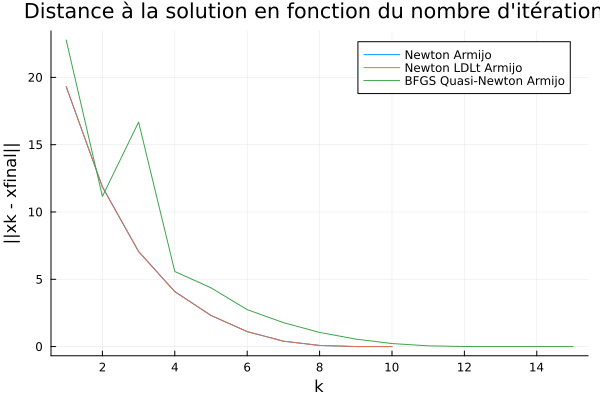

In [169]:
""" On veut réaliser les figures suivantes :
 — Affichage de la distance à la solution trouvé en fonction du nombre d’itération, i.e. ∥xk − xfinal∥ en fonction de k."""

L_newton_ameliore = [norm(L_newton_ameliore[i] - sol_newton_am) for i in 1:length(L_newton_ameliore)]
L_newton_ldlt = [norm(L_newton_ldlt[i] - sol_newton_ldlt) for i in 1:length(L_newton_ldlt)]
L_bfgs = [norm(L_bfgs[i] - sol_bfgs) for i in 1:length(L_bfgs)]

using Plots
plot(1:length(L_newton_ameliore), L_newton_ameliore, label = "Newton Armijo", xlabel = "k", ylabel = "||xk - xfinal||", title = "Distance à la solution en fonction du nombre d'itérations")
plot!(1:length(L_newton_ldlt), L_newton_ldlt, label = "Newton LDLt Armijo")
plot!(1:length(L_bfgs), L_bfgs, label = "BFGS Quasi-Newton Armijo")


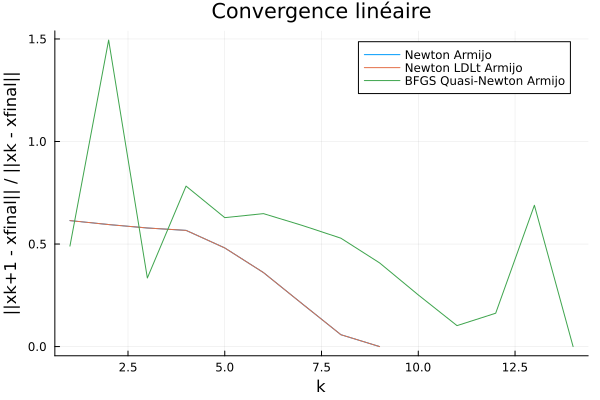

In [170]:
""" — Convergence linéaire : ∥xk+1−xfinal∥ / ∥xk −xf inal ∥ en fonction de k."""
plot(1:length(L_newton_ameliore)-1, L_newton_ameliore[2:end] ./ L_newton_ameliore[1:end-1], label = "Newton Armijo", xlabel = "k", ylabel = "||xk+1 - xfinal|| / ||xk - xfinal||", title = "Convergence linéaire")
plot!(1:length(L_newton_ldlt)-1, L_newton_ldlt[2:end] ./ L_newton_ldlt[1:end-1], label = "Newton LDLt Armijo")
plot!(1:length(L_bfgs)-1, L_bfgs[2:end] ./ L_bfgs[1:end-1], label = "BFGS Quasi-Newton Armijo")


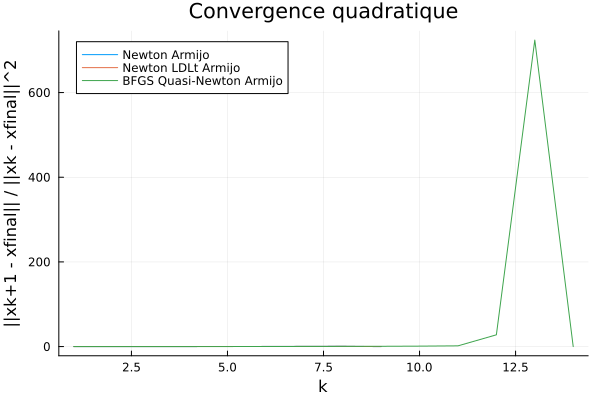

In [171]:
""" — Convergence quadratique : ∥xk+1−xfinal∥ / ∥xk −xfinal ∥^2 en fonction de k."""

plot(1:length(L_newton_ameliore)-1, L_newton_ameliore[2:end] ./ L_newton_ameliore[1:end-1].^2, label = "Newton Armijo", xlabel = "k", ylabel = "||xk+1 - xfinal|| / ||xk - xfinal||^2", title = "Convergence quadratique")
plot!(1:length(L_newton_ldlt)-1, L_newton_ldlt[2:end] ./ L_newton_ldlt[1:end-1].^2, label = "Newton LDLt Armijo")
plot!(1:length(L_bfgs)-1, L_bfgs[2:end] ./ L_bfgs[1:end-1].^2, label = "BFGS Quasi-Newton Armijo")

On remarque que les algorithmes de type newton factorisation et améliorés ont les mêmes itérés quasiment et convergent quadratiquement selon le dernier graphe.
Cependant, bfgs a tendance à prendre plus de temps car c'est un méthode de premier ordre (pas de hessienne) et la convergence n'est pas quadratique mais plutot super linéaire.

### Exercice 4: application à un problème de grande taille

On va ajouter le package `OptimizationProblems` qui contient, comme son nom l'indique, une collection de problème d'optimisation disponible au format de `JuMP` (dans le sous-module `OptimizationProblems.PureJuMP`) et de `ADNLPModel` (dans le sous-module `OptimizationProblems.ADNLPProblems`).

In [26]:
import Pkg; Pkg.add("OptimizationProblems")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed OptimizationProblems ─ v0.5.0


    Updating `~/.julia/environments/v1.8/Project.toml`
⌃ [5049e819] + OptimizationProblems v0.5.0
    Updating `~/.julia/environments/v1.8/Manifest.toml`


⌃ [5049e819] + OptimizationProblems v0.5.0
  [6e34b625] ↑ Bzip2_jll v1.0.8+0 ⇒ v1.0.8+1
        Info Packages marked with ⌃ have new versions available and may be upgradable.


Precompiling 

project...


  ✓ OptimizationProblems
  1 dependency successfully precompiled in 52 seconds. 531 already precompiled. 6 skipped during auto due to previous errors.


In [42]:
using ADNLPModels, OptimizationProblems.ADNLPProblems # Attention si vous ne faites pas using ADNLPModels avant ça ne fonctionne pas!

In [73]:
n = 500
model = genrose(n=n)
@test typeof(model) <: ADNLPModel

Test Passed

Si vous le souhaitez, il est possible d'accéder à certaines informations sur le problème en accédant à son meta:

In [44]:
using OptimizationProblems
OptimizationProblems.genrose_meta

Dict{Symbol, Any} with 17 entries:
  :has_equalities_only    => false
  :origin                 => :unknown
  :has_inequalities_only  => false
  :defined_everywhere     => missing
  :has_fixed_variables    => false
  :variable_ncon          => false
  :nvar                   => 100
  :is_feasible            => true
  :minimize               => true
  :ncon                   => 0
  :name                   => "genrose"
  :best_known_lower_bound => -Inf
  :objtype                => :other
  :best_known_upper_bound => 405.106
  :has_bounds             => false
  :variable_nvar          => true
  :contype                => :unconstrained

Il est aussi possible d'accéder au meta de tous les problèmes

In [30]:
OptimizationProblems.meta

,nvar,variable_nvar,ncon,variable_ncon,minimize,name,has_equalities_only
,Int64,Bool,Int64,Bool,Bool,String,Bool
1,1,0,0,0,1,AMPGO02,0
2,1,0,0,0,1,AMPGO03,0
3,1,0,0,0,1,AMPGO04,0
4,1,0,0,0,1,AMPGO05,0
5,1,0,0,0,1,AMPGO06,0
6,1,0,0,0,1,AMPGO07,0
7,1,0,0,0,1,AMPGO08,0
8,1,0,0,0,1,AMPGO09,0
9,1,0,0,0,1,AMPGO10,0


Résoudre le problème `genrose` et un autre problème de la collection en utilisant vos algorithmes précédents.
Avant d'utiliser l'algorithme on testera que le problème est bien sans contrainte avec:

In [74]:
unconstrained(model) #qui retourne vrai si `nlp` est un problème sans contraintes.

true

In [75]:
model.meta.x0

500-element Vector{Float64}:
 0.001996007984031936
 0.003992015968063872
 0.005988023952095809
 0.007984031936127744
 0.00998003992015968
 0.011976047904191617
 0.013972055888223553
 0.015968063872255488
 0.017964071856287425
 0.01996007984031936
 ⋮
 0.9820359281437125
 0.9840319361277445
 0.9860279441117764
 0.9880239520958084
 0.9900199600798403
 0.9920159680638723
 0.9940119760479041
 0.9960079840319361
 0.998003992015968

In [174]:
bfgs_quasi_newton_armijo(model, model.meta.x0)[1]

 k        fk ||∇f(x)||
 0  1.87e+03   3.0e+02
 1  1.36e+03   5.8e+02 1.7e-02 
 2  1.28e+03   6.5e+02 7.7e-03 
 3  1.25e+03   7.2e+02 7.7e-03 
 4  1.24e+03   7.0e+02 1.5e-03 


 5  1.21e+03   7.3e+02 5.1e-03 
 6  1.20e+03   7.4e+02 2.3e-03 
 7  1.19e+03   7.5e+02 5.1e-03 
 8  1.18e+03   7.4e+02 2.3e-03 
 9  1.16e+03   7.5e+02 5.1e-03 
10  1.16e+03   7.6e+02 3.4e-03 
11  1.12e+03   7.7e+02 5.1e-03 
12  1.11e+03   9.2e+02 5.1e-03 


13  9.66e+02   1.1e+03 5.1e-03 
14  8.17e+02   8.6e+02 2.3e-03 
15  7.85e+02   6.2e+02 2.3e-03 
16  7.55e+02   4.4e+02 2.3e-03 
17  7.38e+02   3.8e+02 2.3e-03 
18  7.30e+02   3.6e+02 2.3e-03 


19  7.30e+02   3.9e+02 5.1e-03 
20  7.27e+02   4.2e+02 5.1e-03 
21  7.24e+02   4.4e+02 3.4e-03 
22  7.23e+02   4.4e+02 3.4e-03 
23  7.20e+02   4.4e+02 5.1e-03 
24  7.17e+02   4.3e+02 5.1e-03 
25  7.08e+02   4.4e+02 7.7e-03 
26  7.00e+02   4.2e+02 5.1e-03 


27  6.84e+02   3.7e+02 3.4e-03 
28  6.61e+02   3.6e+02 3.4e-03 
29  6.33e+02   4.0e+02 3.4e-03 
30  6.22e+02   4.3e+02 3.4e-03 
31  6.14e+02   4.2e+02 3.4e-03 
32  5.98e+02   3.8e+02 2.3e-03 
33  5.84e+02   3.8e+02 2.3e-03 
34  5.78e+02   4.1e+02 3.4e-03 


35  5.68e+02   3.8e+02 2.3e-03 
36  5.64e+02   4.0e+02 3.4e-03 
37  5.64e+02   4.1e+02 3.4e-03 
38  5.62e+02   4.4e+02 3.4e-03 
39  5.57e+02   4.5e+02 2.3e-03 
40  5.57e+02   4.6e+02 2.3e-03 


41  5.56e+02   4.5e+02 1.5e-03 
42  5.53e+02   4.6e+02 7.7e-03 
43  5.38e+02   4.4e+02 7.7e-03 
44  5.30e+02   4.1e+02 3.4e-03 
45  5.10e+02   3.5e+02 2.3e-03 
46  5.04e+02   4.4e+02 5.1e-03 


47  4.70e+02   3.9e+02 3.4e-03 
48  4.61e+02   3.7e+02 3.4e-03 


49  4.58e+02   3.2e+02 2.3e-03 
50  4.55e+02   3.2e+02 3.4e-03 
51  4.51e+02   3.1e+02 3.4e-03 
52  4.50e+02   3.1e+02 3.4e-03 


53  4.48e+02   3.0e+02 3.4e-03 
54  4.46e+02   2.9e+02 3.4e-03 
55  4.44e+02   2.7e+02 2.3e-03 
56  4.43e+02   2.7e+02 3.4e-03 
57  4.43e+02   2.8e+02 5.1e-03 
58  4.42e+02   2.8e+02 5.1e-03 


59  4.40e+02   2.8e+02 5.1e-03 
60  4.36e+02   2.8e+02 5.1e-03 
61  4.25e+02   2.9e+02 5.1e-03 
62  4.23e+02   3.4e+02 5.1e-03 
63  4.09e+02   2.9e+02 3.4e-03 
64  3.99e+02   2.8e+02 3.4e-03 
65  3.89e+02   2.4e+02 2.3e-03 
66  3.86e+02   2.4e+02 2.3e-03 


67  3.86e+02   2.4e+02 2.3e-03 
68  3.85e+02   2.4e+02 2.3e-03 
69  3.85e+02   2.4e+02 3.4e-03 
70  3.85e+02   2.4e+02 5.1e-03 


71  3.84e+02   2.4e+02 5.1e-03 
72  3.81e+02   2.4e+02 5.1e-03 
73  3.75e+02   2.5e+02 5.1e-03 
74  3.71e+02   2.6e+02 5.1e-03 
75  3.60e+02   2.3e+02 3.4e-03 
76  3.50e+02   2.0e+02 2.3e-03 
77  3.45e+02   2.0e+02 2.3e-03 
78  3.43e+02   2.0e+02 2.3e-03 


79  3.42e+02   1.9e+02 2.3e-03 
80  3.42e+02   1.9e+02 2.3e-03 


81  3.42e+02   1.9e+02 3.4e-03 
82  3.42e+02   1.9e+02 3.4e-03 
83  3.42e+02   1.9e+02 5.1e-03 
84  3.41e+02   1.9e+02 7.7e-03 
85  3.41e+02   2.0e+02 7.7e-03 
86  3.38e+02   1.8e+02 5.1e-03 


87  3.34e+02   1.6e+02 3.4e-03 
88  3.33e+02   1.6e+02 3.4e-03 
89  3.31e+02   1.5e+02 2.3e-03 
90  3.30e+02   1.5e+02 2.3e-03 
91  3.30e+02   1.5e+02 2.3e-03 
92  3.30e+02   1.4e+02 2.3e-03 
93  3.30e+02   1.4e+02 3.4e-03 
94  3.30e+02   1.4e+02 5.1e-03 


95  3.29e+02   1.4e+02 5.1e-03 
96  3.28e+02   1.5e+02 7.7e-03 


97  3.26e+02   1.4e+02 5.1e-03 
98  3.22e+02   1.1e+02 3.4e-03 
99  3.20e+02   1.3e+02 3.4e-03 
100  3.18e+02   1.1e+02 2.3e-03 


500-element Vector{Float64}:
  0.7556370446736108
  0.5708444314086638
  0.30546409050141393
  0.04958650590383712
  0.022576698668703897
 -0.03880469090089532
  0.05891487786079695
  0.022175970793598704
  0.0010219935141448791
 -0.0019124367106710287
  ⋮
  0.9872369341611383
  0.960286714215146
  0.8791243023440348
  0.7967001804172916
  0.6753529095343201
  0.4995721290219445
  0.2997993668799243
  0.19714466112648465
  0.046364219825971956

In [175]:
# Use previous functions to solve genrose.
newton_ldlt_armijo(model, model.meta.x0)[1]

 k        fk ||∇f(x)||
 0  1.87e+03   3.0e+02


 1  1.85e+03   2.9e+02 3.5e-06 
 2  1.84e+03   2.8e+02 3.0e-04 


 3  1.83e+03   2.7e+02 4.5e-04 
 4  1.82e+03   2.8e+02 1.5e-03 


 5  1.76e+03   3.1e+02 7.7e-03 
 6  1.73e+03   3.2e+02 5.1e-03 


 7  1.69e+03   4.3e+02 2.6e-02 
 8  1.63e+03   4.8e+02 7.7e-03 


 9  1.54e+03   4.9e+02 1.2e-02 
10  1.51e+03   5.1e+02 5.1e-03 


11  1.50e+03   5.3e+02 7.7e-03 
12  1.43e+03   5.6e+02 5.9e-02 


13  1.41e+03   6.5e+02 1.7e-02 
14  1.39e+03   6.5e+02 2.3e-03 


15  1.38e+03   6.5e+02 3.4e-03 
16  1.30e+03   6.4e+02 5.9e-02 


17  1.27e+03   6.7e+02 1.2e-02 
18  1.17e+03   6.5e+02 1.3e-01 


19  1.03e+03   6.5e+02 3.0e-01 
20  9.63e+02   6.2e+02 3.0e-01 


21  8.75e+02   5.7e+02 1.3e-01 
22  8.43e+02   5.8e+02 2.6e-02 


23  7.17e+02   4.5e+02 3.0e-01 
24  6.85e+02   4.2e+02 8.8e-02 


25  6.63e+02   4.2e+02 1.2e-02 
26  4.90e+02   1.2e+02 1.0e+00 


27  4.72e+02   1.2e+02 3.0e-01 
28  4.50e+02   1.5e+02 5.9e-02 


29  4.30e+02   1.7e+02 1.0e-03 
30  4.06e+02   4.9e+01 1.0e+00 


31  4.01e+02   1.8e+01 1.0e+00 
32  4.01e+02   1.8e+01 1.3e-01 


33  4.01e+02   3.8e+01 1.0e+00 
34  4.00e+02   4.2e+01 5.9e-02 


35  3.97e+02   2.7e+01 1.0e+00 
36  3.96e+02   4.7e+01 1.0e+00 


37  3.96e+02   4.8e+01 1.0e+00 
38  3.91e+02   1.5e+01 1.0e+00 


39  3.88e+02   3.9e+01 1.0e+00 
40  3.86e+02   6.6e+01 3.0e-01 


41  3.84e+02   7.7e+01 8.8e-02 
42  3.65e+02   1.0e+02 2.0e-01 


43  3.56e+02   2.3e+02 1.3e-01 
44  3.36e+02   1.2e+02 6.7e-01 


45  3.21e+02   2.4e+01 1.0e+00 
46  3.19e+02   7.9e+00 1.0e+00 


47  3.18e+02   1.3e+01 1.0e+00 
48  3.17e+02   6.2e+00 1.0e+00 


49  3.16e+02   2.1e+01 1.0e+00 
50  3.14e+02   8.8e+00 1.0e+00 


51  3.14e+02   1.8e+01 6.7e-01 
52  3.12e+02   9.3e+00 6.7e-01 


53  3.12e+02   1.4e+01 6.7e-01 
54  3.12e+02   3.8e+01 1.0e+00 


55  3.11e+02   3.7e+01 1.0e+00 
56  3.09e+02   9.3e+00 1.0e+00 


57  3.08e+02   1.2e+01 1.0e+00 
58  3.06e+02   7.2e+00 1.0e+00 


59  3.06e+02   1.0e+01 6.7e-01 
60  3.06e+02   1.7e+01 1.7e-02 


61  3.05e+02   1.3e+01 4.4e-01 
62  3.04e+02   2.1e+01 4.4e-01 


63  3.03e+02   3.2e+01 6.7e-01 
64  3.02e+02   8.9e+00 1.0e+00 


65  3.01e+02   9.8e+00 1.0e+00 
66  2.99e+02   1.2e+01 1.0e+00 


67  2.99e+02   1.4e+01 1.0e+00 
68  2.98e+02   6.3e+00 1.0e+00 


69  2.97e+02   1.5e+01 1.0e+00 
70  2.95e+02   5.8e+00 1.0e+00 


71  2.95e+02   1.6e+01 6.7e-01 
72  2.95e+02   3.8e+01 1.0e+00 


73  2.94e+02   1.7e+01 4.4e-01 
74  2.92e+02   1.7e+01 1.0e+00 


75  2.91e+02   6.3e+00 1.0e+00 
76  2.90e+02   1.4e+01 6.7e-01 


77  2.90e+02   1.5e+01 1.3e-01 
78  2.89e+02   6.9e+00 1.0e+00 


79  2.88e+02   1.3e+01 3.9e-02 
80  2.88e+02   1.3e+01 6.7e-01 


81  2.86e+02   9.4e+00 1.0e+00 
82  2.85e+02   7.6e+00 1.0e+00 


83  2.85e+02   1.7e+01 1.0e+00 
84  2.83e+02   6.3e+00 1.0e+00 


85  2.83e+02   1.8e+01 6.7e-01 
86  2.83e+02   1.6e+01 1.3e-01 


87  2.81e+02   1.1e+01 1.0e+00 
88  2.80e+02   2.5e+01 1.0e+00 


89  2.79e+02   1.1e+01 4.4e-01 
90  2.79e+02   1.8e+01 1.0e+00 


91  2.77e+02   6.6e+00 1.0e+00 
92  2.76e+02   1.5e+01 6.7e-01 


93  2.75e+02   6.1e+00 1.0e+00 
94  2.75e+02   3.1e+01 1.0e+00 


95  2.73e+02   9.5e+00 1.0e+00 
96  2.72e+02   1.6e+01 6.7e-01 


97  2.71e+02   9.7e+00 6.7e-01 
98  2.71e+02   2.3e+01 1.0e+00 


99  2.69e+02   2.0e+01 6.7e-01 
100  2.69e+02   1.4e+01 5.9e-02 


500-element Vector{Float64}:
 0.9999999999999614
 0.9999999999999224
 0.9999999999998442
 0.9999999999996876
 0.9999999999993732
 0.9999999999987421
 0.9999999999974758
 0.9999999999949348
 0.9999999999898358
 0.999999999979604
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0